In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [4]:
df = pd.read_csv('/Users/Haebichan/Desktop/crime data.csv', parse_dates = ['Time Occurred'])

In [5]:
df.columns = [col.strip() for col in df.columns] # Always check to see if there are problems with the data column name
df.columns

Index(['DR Number', 'Date Reported', 'Date Occurred', 'Time Occurred',
       'Area ID', 'Area Name', 'Reporting District', 'Crime Code',
       'Crime Code Description', 'MO Codes', 'Victim Age', 'Victim Sex',
       'Victim Descent', 'Premise Code', 'Premise Description',
       'Weapon Used Code', 'Weapon Description', 'Status Code',
       'Status Description', 'Crime Code 1', 'Crime Code 2', 'Crime Code 3',
       'Crime Code 4', 'Address', 'Cross Street', 'Location'],
      dtype='object')

# Analyzing of crimes from a broad perspective

In [6]:
df["Crime Code Description"].value_counts() # We have about 148 different types of crimes committed in LA

BATTERY - SIMPLE ASSAULT                                        160176
BURGLARY FROM VEHICLE                                           135032
VEHICLE - STOLEN                                                134830
BURGLARY                                                        125975
THEFT PLAIN - PETTY ($950 & UNDER)                              124666
THEFT OF IDENTITY                                               109739
INTIMATE PARTNER - SIMPLE ASSAULT                                94907
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS) 0114     88442
VANDALISM - MISDEAMEANOR ($399 OR UNDER)                         77903
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT                   75268
THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER)                  71954
ROBBERY                                                          70174
THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LIVESTK,PROD0036     61610
CRIMINAL THREATS - NO WEAPON DISPLAYED                           48610
SHOPLI

In [7]:
# Creating and extracting from the Datetime Column

df["Time Occurred"] = df["Time Occurred"].astype(str) 
df['Time Occurred'] = [i[:-2] + ':' + i[-2:] + ':00' for i in df['Time Occurred']]
df["Datetime"] = pd.to_datetime(df["Date Occurred"] + " " + df["Time Occurred"], format = "%m/%d/%Y %H:%M:%S") 

df['hour occurred'] = df["Datetime"].apply(lambda x: x.hour)
df['month occurred'] = df["Datetime"].apply(lambda x: x.month)
df['weekday occurred'] = df["Datetime"].apply(lambda x: x.weekday())
df['dom occurred'] = df["Datetime"].apply(lambda x: x.day)
df['day occurred'] = df["Datetime"].apply(lambda x: x.weekday_name)
df['year occurred'] = df['Datetime'].apply(lambda x: x.year)

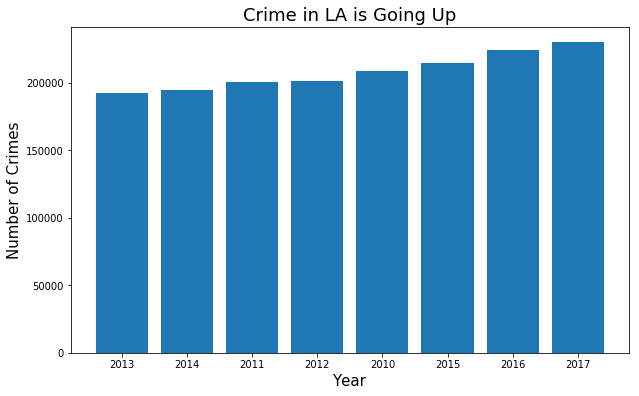

In [8]:
# Notice that crimes in LA in general have been gradually growing every year

mask_year = df['year occurred'] <= 2017
n_crime = df[mask_year]['year occurred'].value_counts().sort_values()

figure = figsize(10,6)
bar(range(n_crime.shape[0]), n_crime)
xticks(range(n_crime.shape[0]), n_crime.index)
xlabel('Year', size = 15)
ylabel('Number of Crimes', size = 15)
title('Crime in LA is Going Up', size = 18);

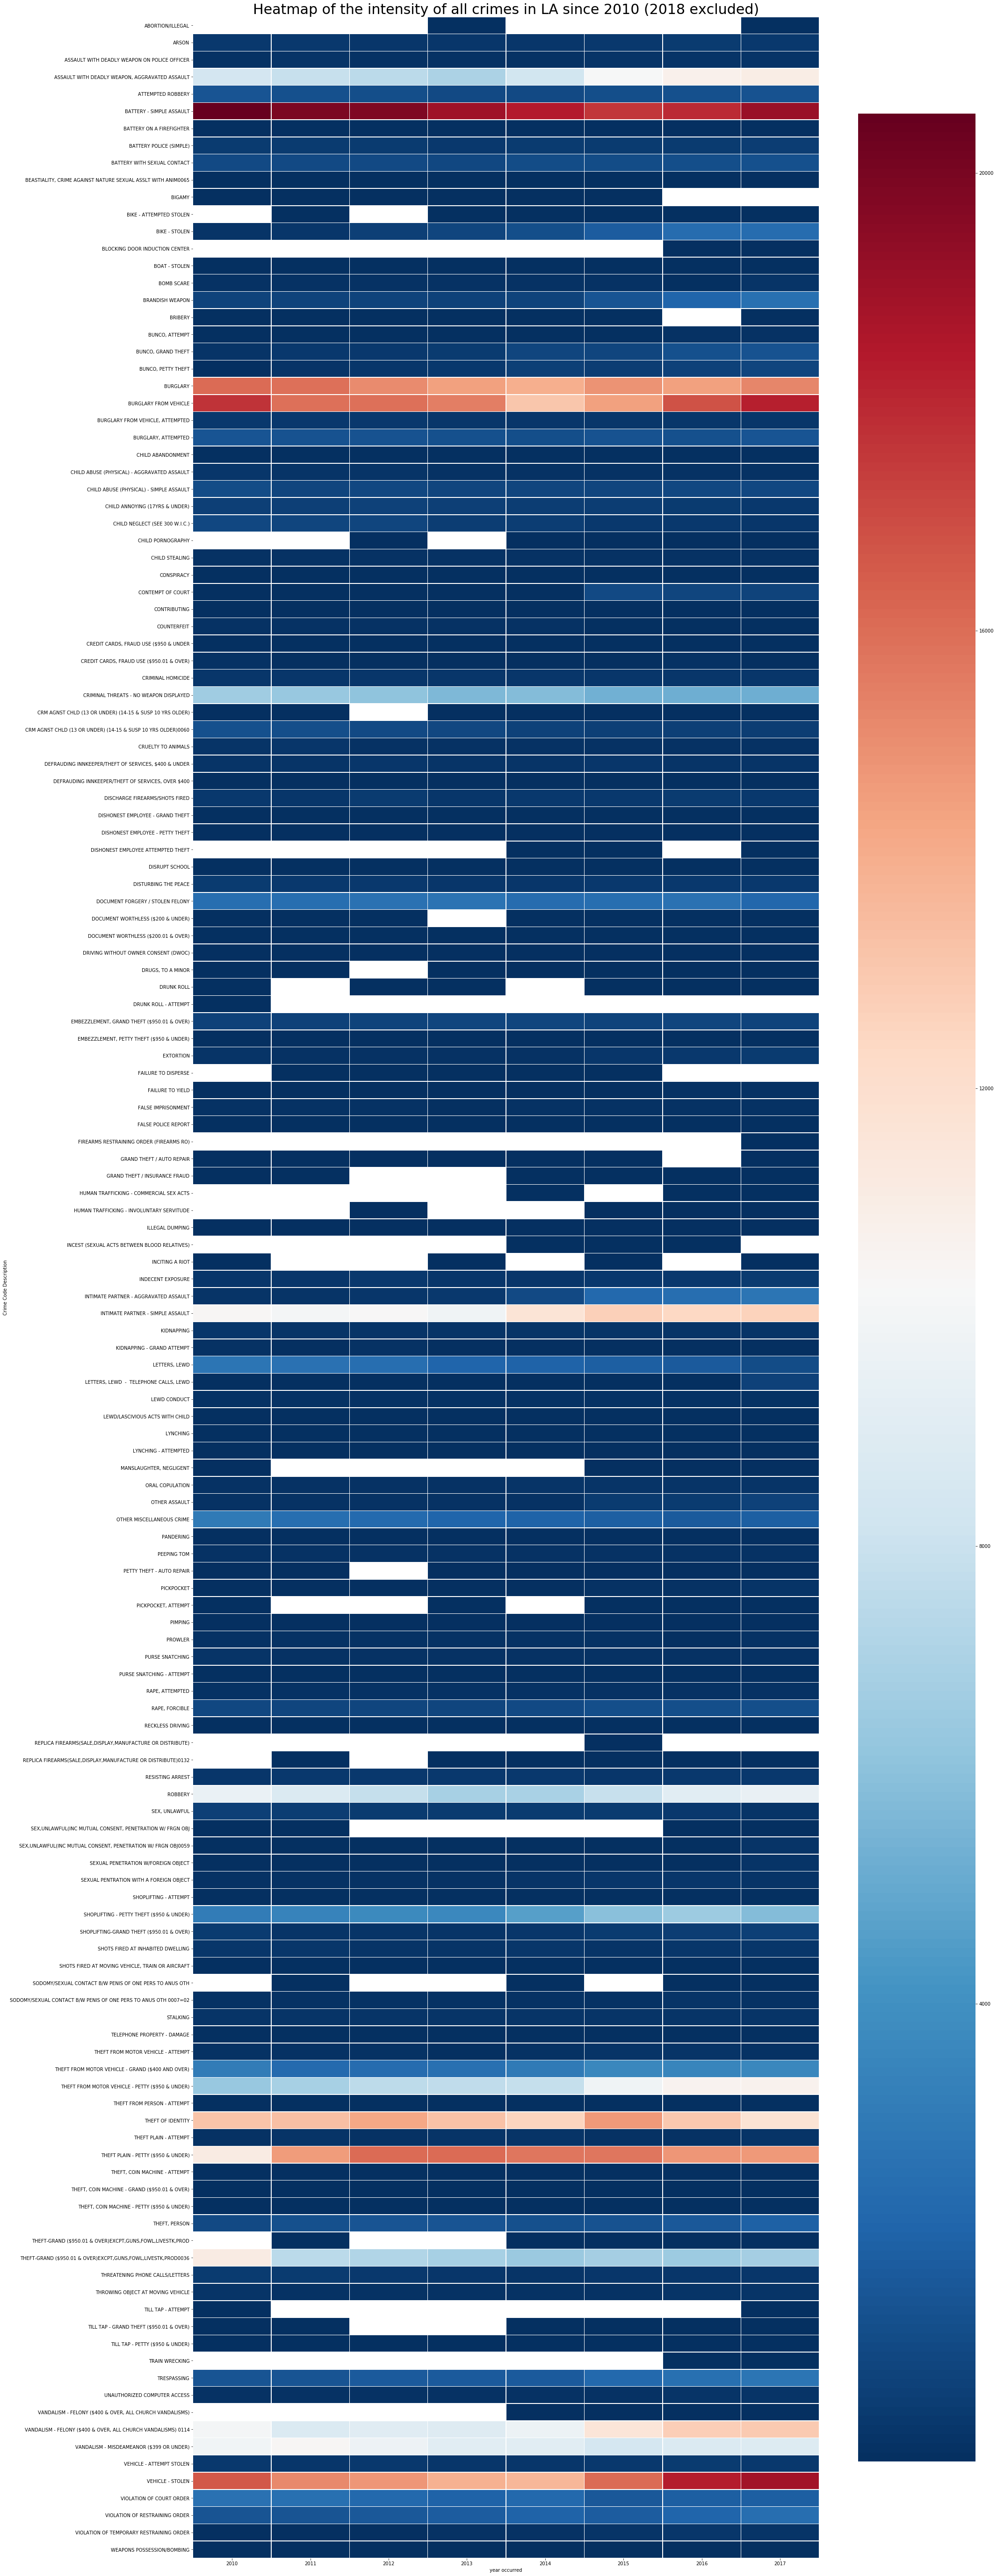

In [9]:
# Using a heatmap, we can visualize which type of crime happens more frequently in LA. Notice that Battery (simple assault), stolen vehicle, burglary, and general theft are among the biggest crimes, with many picking up in intensity during 2016 and 2017. 

mask_year = df['year occurred'] <= 2017
n_crime = df[mask_year][['Crime Code Description', 'year occurred']]
m = n_crime.groupby(['Crime Code Description', 'year occurred']).apply(lambda x: len(x)).unstack()
figure = figsize(30, 100)

sns.heatmap(m, cmap='RdBu_r', linewidth=0.5);
title('Heatmap of the intensity of all crimes in LA since 2010 (2018 excluded)', fontsize = 30);

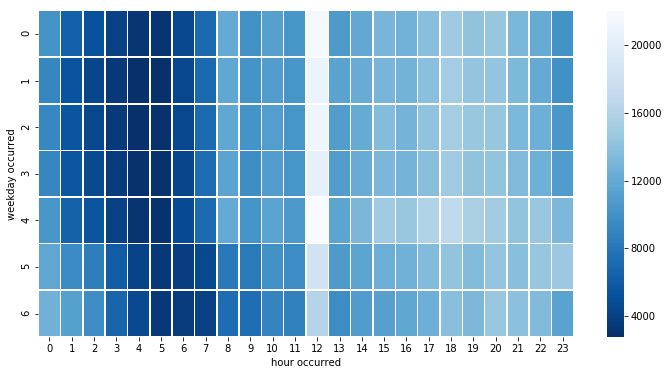

In [32]:
# With heatmap, we can notice some interesting time-related trends. For instance, 12 at noon seems to be the time when all types crimes occur the most, which goes against the perception that nighttime is when crimes happen the most.
m = df.groupby(['weekday occurred','hour occurred']).apply(count_rows).unstack()
figure = figsize(12,6)
sns.heatmap(m, cmap='Blues_r', linewidth=0.5);

# Pursuing granularity by focusing on top 5 crimes in LA

In [10]:
# Now that we've looked at all crimes, let's focus on the top 5.

first_n = 5
print(df['Crime Code Description'].value_counts(1)[:first_n].sum())

other = 1-df["Crime Code Description"].value_counts(1)[:first_n].sum()
top_5_crime = df["Crime Code Description"].value_counts(1)[:first_n].index
print(top_5_crime.values)

0.38786631048952325
['BATTERY - SIMPLE ASSAULT' 'BURGLARY FROM VEHICLE' 'VEHICLE - STOLEN'
 'BURGLARY' 'THEFT PLAIN - PETTY ($950 & UNDER)']


In [11]:
def count_rows(x):
    return len(x)

df2 = df.groupby(['year occurred','Crime Code Description']).apply(count_rows).unstack()
df2.head()
df2.reset_index(inplace = True)

Text(0.5,1,'Frequency of Top 5 Crimes Since 2010')

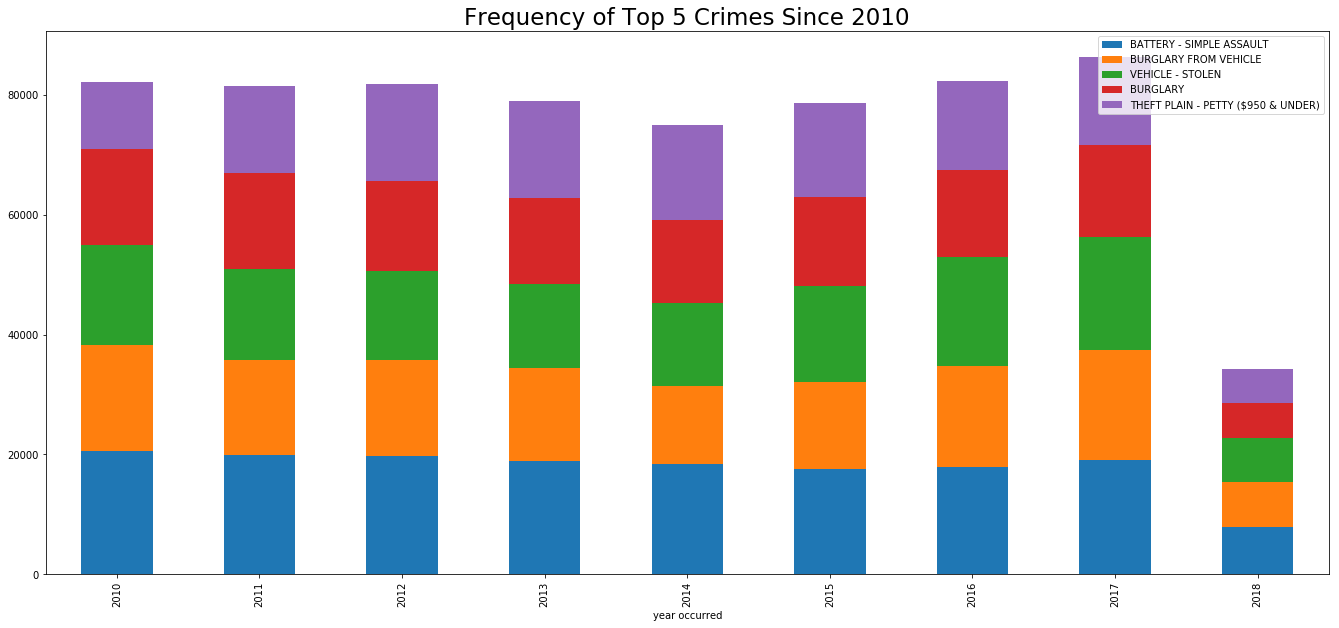

In [12]:
figure = figsize(23,10) 
df2.plot.bar(x= "year occurred", y = top_5_crime, stacked = True);
legend();
title('Frequency of Top 5 Crimes Since 2010', size = 23)

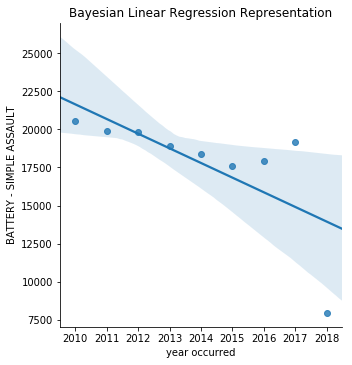

In [13]:
# We can zoom in a little further by looking specifically at the trend of Battery/Assault. The graph below shows a bayesian linear regression which comes with the line of best fit and the confidence interval that shows the confidence of predictions. The 2012-2013 are years with the highest confidence in our prediction|

sns.lmplot(data = df2, x = "year occurred", y = "BATTERY - SIMPLE ASSAULT" );
title("Bayesian Linear Regression Representation");

### Top five crimes visualized through geographical coordinates 

In [14]:
coordinates = df['Location'].str.strip('()').str.split(', ', expand = True).rename(columns = {0: 'Latitude', 1: 'Longitude'})
df = df.join(coordinates)
df['Latitude'] = df['Latitude'].astype(float) 
df['Longitude'] = df['Longitude'].astype(float) 
df['Longitude'].describe()
df['Latitude'].describe()

count    1.755309e+06
mean     3.393657e+01
std      2.198905e+00
min      0.000000e+00
25%      3.400910e+01
50%      3.406250e+01
75%      3.417740e+01
max      3.479070e+01
Name: Latitude, dtype: float64

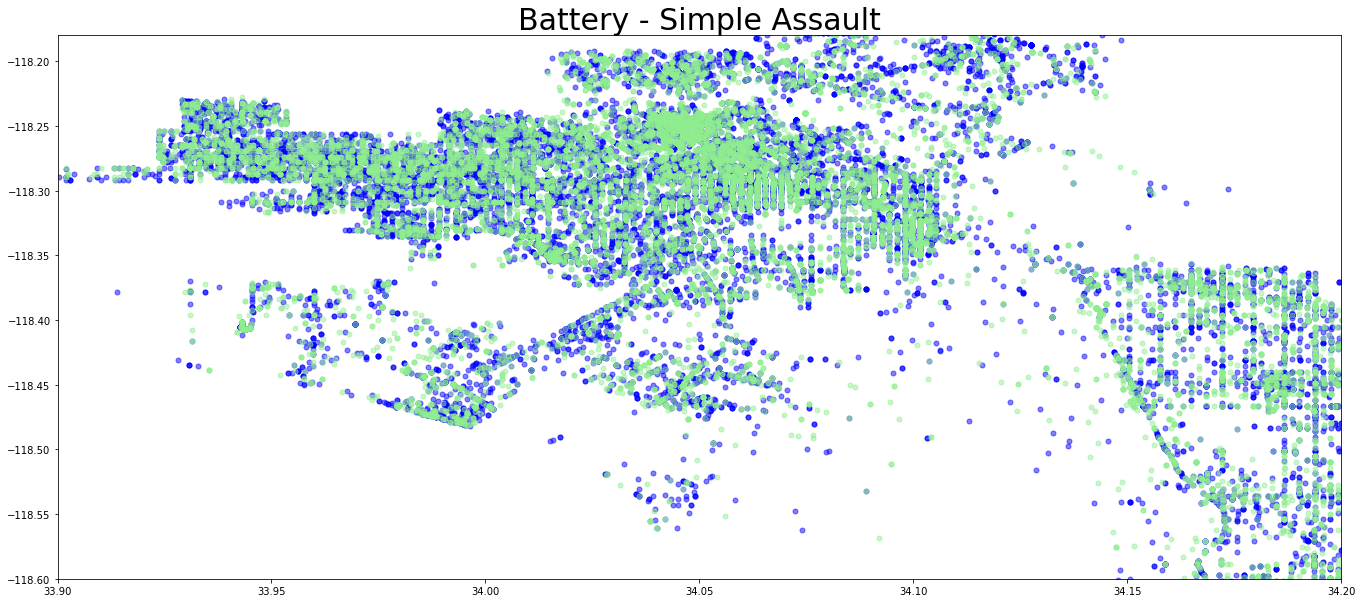

In [15]:
# Using geographical coordinates, we can visually compare the frequency of crimes between year 2010 and 2017. For instance, battery has been very densen in certain areas, centralizing at around the coordinates (34.05 and -118.25). This is the Downtown LA area, next to Japantown

xlim(33.9, 34.2);
ylim(-118.6, -118.180);
title('Battery - Simple Assault', fontsize=30);
years= [2010, 2017]
colors = ['b', 'lightgreen']
alphas = [0.5, 0.5]
for year, color, alpha in zip(years,colors, alphas) :
    x = df[(df["Crime Code Description"]=="BATTERY - SIMPLE ASSAULT") & (df["year occurred"]==year)]["Latitude"]
    y = df[(df["Crime Code Description"]=="BATTERY - SIMPLE ASSAULT") & (df["year occurred"]==year)]["Longitude"]

    plot(x, y, '.', ms=10, color=color, alpha = alpha);

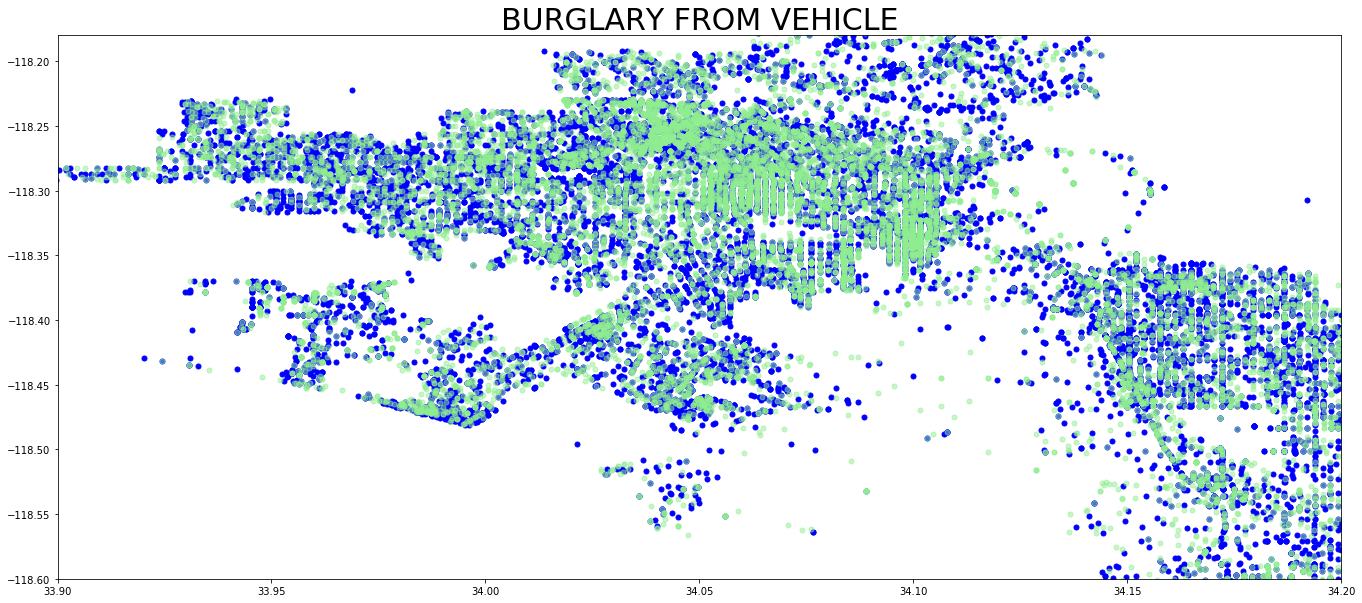

In [16]:
# Notice the crime 'Burglary from Vehicle' has also become concentrated in particular areas as well. 
xlim(33.9, 34.2);
ylim(-118.6, -118.180);
title('BURGLARY FROM VEHICLE', fontsize=30);
years= [2010, 2017]
colors = ['b', 'lightgreen']
alphas = [1, 0.5]
for year, color, alpha in zip(years,colors, alphas) :
    x = df[(df["Crime Code Description"]=="BURGLARY FROM VEHICLE") & (df["year occurred"]==year)]["Latitude"]
    y = df[(df["Crime Code Description"]=="BURGLARY FROM VEHICLE") & (df["year occurred"]==year)]["Longitude"]

    plot(x, y, '.', ms=10, color=color, alpha = alpha);

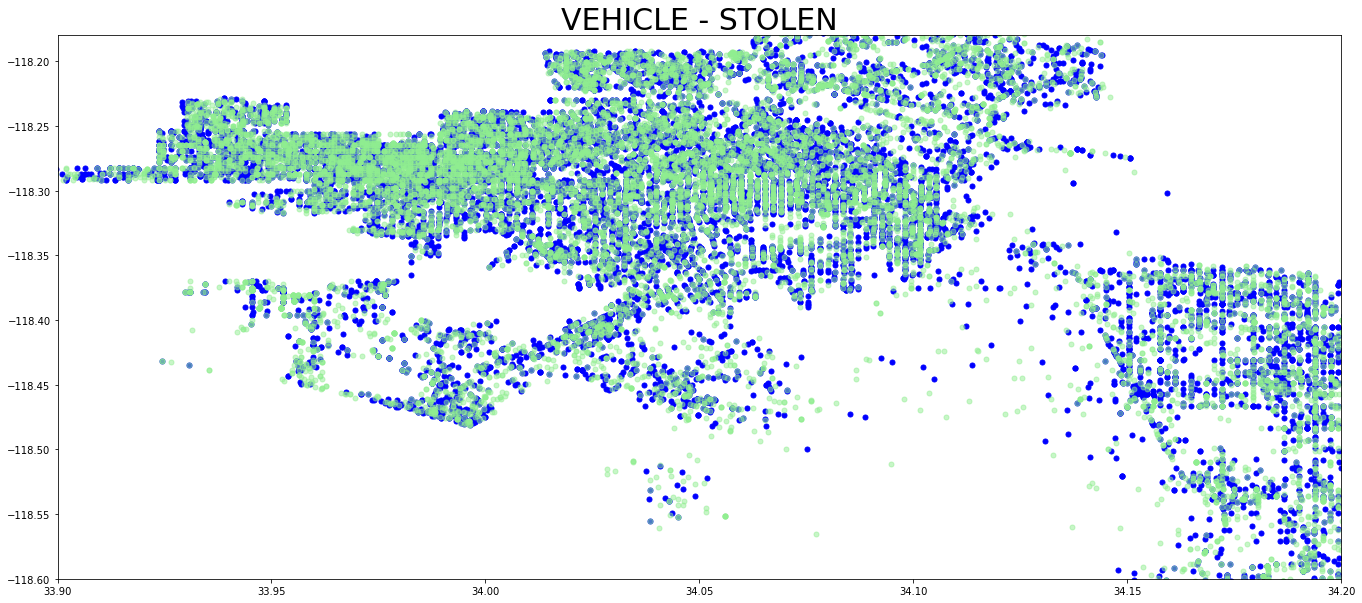

In [17]:
# Certain crimes happen in certain area. To target a certain crime, focus on a certain area. Crime has become more concentrated in certain areas. For certain crime graphs, crime becomes more dense over time.

xlim(33.9, 34.2);
ylim(-118.6, -118.180);
title("VEHICLE - STOLEN", fontsize=30);
years= [2010, 2017]
colors = ['b', 'lightgreen']
alphas = [1, 0.5]
for year, color, alpha in zip(years,colors, alphas) :
    x = df[(df["Crime Code Description"]=="VEHICLE - STOLEN") & (df["year occurred"]==year)]["Latitude"]
    y = df[(df["Crime Code Description"]=="VEHICLE - STOLEN") & (df["year occurred"]==year)]["Longitude"]

    plot(x, y, '.', ms=10, color=color, alpha = alpha);

# Zooming in further by looking at crimes in relation to gender and age

In [18]:
df['Victim Sex'].value_counts()

M    816373
F    745030
X     31938
H        60
-         1
Name: Victim Sex, dtype: int64

In [19]:
df_victime = df.groupby(["Victim Age","Victim Sex"])["DR Number"].count().unstack()[["F","M"]]
df_victime.head()

Victim Sex,F,M
Victim Age,,
10.0,1793.0,5103.0
11.0,2632.0,5651.0
12.0,3733.0,5486.0
13.0,5068.0,6456.0
14.0,6025.0,7450.0


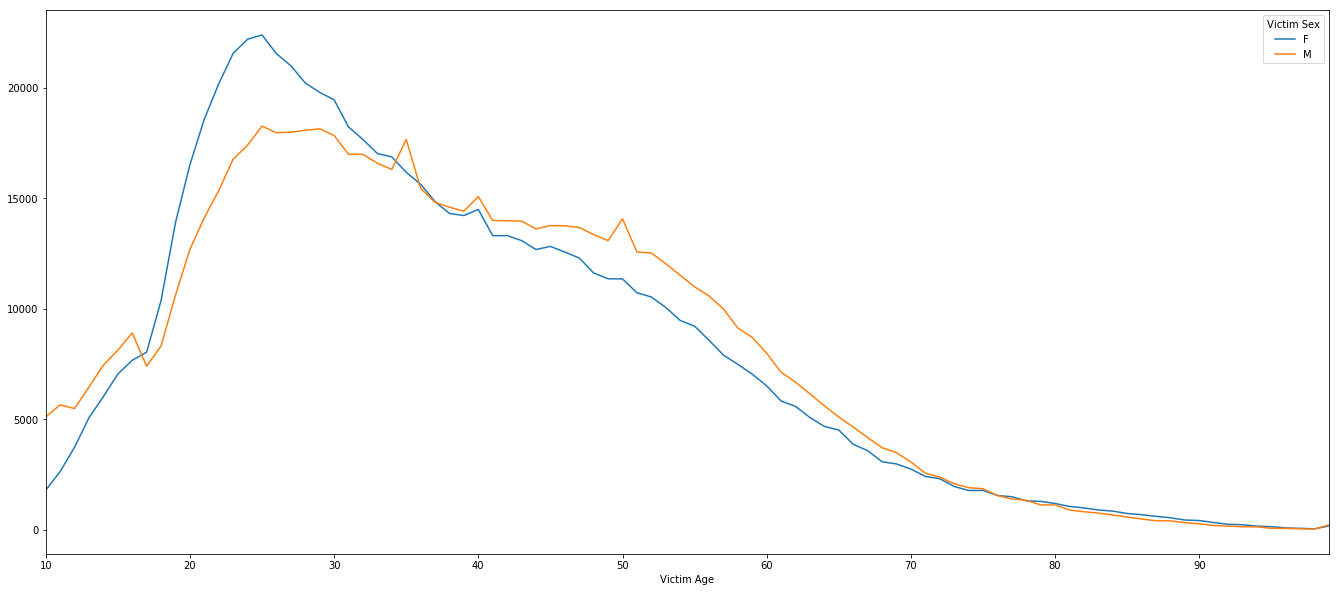

In [20]:
# we notice that young females tend to be victimized more in LA, a trend which reverses to some extent as age becomes greater. 
df_victime.plot();

In [21]:
df1 = df[['Victim Age', 'Victim Sex', 'Victim Descent', 'Area Name', 'Crime Code Description', 'Time Occurred']]

dftemp = df1.groupby('Crime Code Description').agg({'Time Occurred':'count'})
df3 = dftemp[dftemp['Time Occurred'] >= 10000]
df4 = df1.groupby(['Crime Code Description','Victim Sex']).agg({'Time Occurred': "count"})
df4.reset_index(inplace = True)
df4.head()

,Crime Code Description,Victim Sex,Time Occurred
0,ABORTION/ILLEGAL,F,2
1,ABORTION/ILLEGAL,M,3
2,ARSON,F,865
3,ARSON,M,1932
4,ARSON,X,110


In [22]:
df4 = df4[(df4['Victim Sex'] != 'X') & (df4['Victim Sex'] != 'H')]

In [25]:
df4 = df4[df4['Crime Code Description'].apply(lambda x: x in df3.index)]
df4.set_index(['Crime Code Description', 'Victim Sex'], inplace = True)

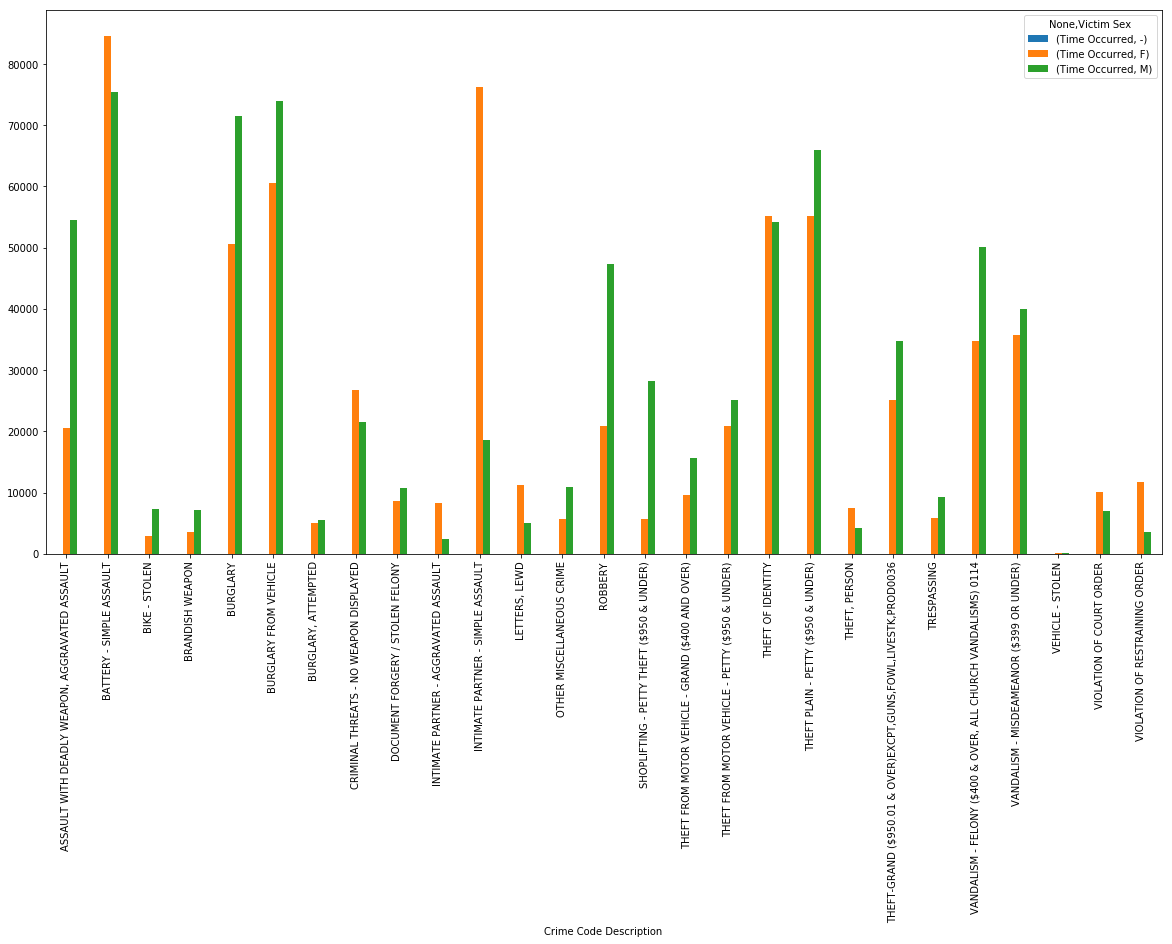

In [27]:
#Through multilevel-indexing, we can compare side-by-side which big crimes tend to affect women compared to men. Some while obvious, like 'Intimate Partner", others are less so, such as bulglaries, which seem to affect males more. 

figure = figsize(20,10)
df4.unstack().plot(kind='bar');